<a href="https://colab.research.google.com/github/IndriPutriMardiana/Pembelajaran_Mesin/blob/main/Jobsheet_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Job Sheet 10 : Recurrent Neural Network (RNN)**

In [ ]:
#Setup
#Impor matplotlib dan buat fungsi pembantu untuk memplot grafik
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


Setup input pipeline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Dataset IMDB reviews biasanya digunakan untuk tugas analisis sentimen di mana tujuannya adalah untuk menentukan apakah suatu ulasan film atau teks memiliki sentimen positif atau negatif. Pada dasarnya, kode ini membantu untuk memuat dataset IMDB reviews, membaginya menjadi data latih dan data uji, dan memberikan informasi tentang struktur data dalam dataset latih

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'You may say to yourself, "Don Johnson as Elvis? Can that work? Is it possible? Seems like an terrible choice to me, but perhaps I should have an open mind. Maybe I\'ll be surprised. Maybe he can pull it off."<br /><br />NOT!<br /><br />Don Johnson is not a bad actor. But he is an awful Elvis. He\'s too short, too weak-voiced, too sharply featured ... well you\'ve already imagined how bad he would be. Add to that a hokey black wig and heavy-handed eye-liner and mascara and it\'s a big fat embarrassing mess.<br /><br />The best I can say is that since Johnson\'s acting is decent and since his impersonation is so far off, after a while you don\'t even think of him as Elvis anymore. You see him as some other crazed pop star instead. Then, on that level, the movie becomes watchable.<br /><br />Stephanie Zimbalist is also not ideally cast as the tall, beauty queen, Linda Thompson. But she is attractive in her own right and plays the part with the honesty, elegance and intelligence

Kode diatas digunakan untuk mempersiapkan dataset pelatihan (train_dataset) dan dataset uji (test_dataset) dalam TensorFlow untuk melatih model machine learning, kemungkinan besar untuk analisis sentimen pada ulasan IMDB. kode ini menyiapkan dataset pelatihan dan uji, mengacak dan membagi batch dataset pelatihan, serta membagi batch dataset uji. Loop terakhir mencetak teks dan label dari batch pertama dataset pelatihan, memberikan gambaran isi dan struktur dataset sebelum digunakan untuk melatih model machine learning.

Buat Teks Encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

digunakan untuk membuat dan mengonfigurasi layer TextVectorization pada TensorFlow, yang berfungsi untuk mengonversi teks menjadi representasi vektor numerik. Layer TextVectorization akan siap digunakan dalam arsitektur model, dan vocabulary-nya akan dibangun berdasarkan data pelatihan yang sebenarnya.

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

kode ini mengambil vocabulary yang telah dibangun oleh layer TextVectorization dan menyimpannya dalam bentuk array NumPy. Langkah ini dapat berguna untuk memeriksa kata-kata apa yang termasuk dalam vocabulary dan dapat membantu dalam pemahaman lebih lanjut tentang representasi teks yang akan digunakan oleh model.

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 23, 194, 130, ...,   0,   0,   0],
       [253, 899,   8, ...,   0,   0,   0],
       [597,  86,   5, ...,   0,   0,   0]])

kode ini mengambil contoh teks dari dataset, menggunakan layer TextVectorization untuk mengonversi teks tersebut menjadi representasi numerik, dan kemudian mencetak hasil encoding-nya. Representasi numerik ini dapat digunakan sebagai input bagi model machine learning untuk pelatihan atau evaluasi.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'You may say to yourself, "Don Johnson as Elvis? Can that work? Is it possible? Seems like an terrible choice to me, but perhaps I should have an open mind. Maybe I\'ll be surprised. Maybe he can pull it off."<br /><br />NOT!<br /><br />Don Johnson is not a bad actor. But he is an awful Elvis. He\'s too short, too weak-voiced, too sharply featured ... well you\'ve already imagined how bad he would be. Add to that a hokey black wig and heavy-handed eye-liner and mascara and it\'s a big fat embarrassing mess.<br /><br />The best I can say is that since Johnson\'s acting is decent and since his impersonation is so far off, after a while you don\'t even think of him as Elvis anymore. You see him as some other crazed pop star instead. Then, on that level, the movie becomes watchable.<br /><br />Stephanie Zimbalist is also not ideally cast as the tall, beauty queen, Linda Thompson. But she is attractive in her own right and plays the part with the honesty, elegance and intelligen

kode ini memberikan pemahaman tentang bagaimana teks asli dan teks yang sudah diencode kemudian didecode kembali (round-trip) dengan menggunakan layer TextVectorization. Ini berguna untuk memeriksa seberapa baik proses encoding-decoding tersebut mempertahankan informasi teks asli.

A drawing of the information flow in the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


model ini memiliki struktur yang melibatkan proses vektorisasi teks, embedding, pemrosesan LSTM bidireksional, dan beberapa lapisan Dense untuk output. Model ini cocok untuk tugas seperti analisis sentimen di mana informasi urutan dalam teks penting. Hasil yang di run antara False dan True.

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00916238]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 589ms/step
[0.00916238]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 655s 2s/step - loss: 0.6255 - accuracy: 0.5896 - val_loss: 0.4519 - val_accuracy: 0.7750
Epoch 2/10
391/391 [==============================] - 619s 2s/step - loss: 0.3843 - accuracy: 0.8282 - val_loss: 0.3526 - val_accuracy: 0.8349
Epoch 3/10
391/391 [==============================] - 631s 2s/step - loss: 0.3332 - accuracy: 0.8532 - val_loss: 0.3370 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 630s 2s/step - loss: 0.3219 - accuracy: 0.8601 - val_loss: 0.3242 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 626s 2s/step - loss: 0.3103 - accuracy: 0.8657 - val_loss: 0.3300 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 631s 2s/step - loss: 0.3072 - accuracy: 0.8670 - val_loss: 0.3214 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 636s 2s/step - loss: 0.3038 - accuracy: 0.8699 - val_loss: 0.3208 - val_accuracy: 0.8536

Proses pelatihan model menggunakan fit ini memanfaatkan dataset pelatihan dan validasi yang sudah disiapkan sebelumnya. Model akan diupdate berdasarkan loss yang dihasilkan selama proses pelatihan. Setelah proses pelatihan selesai, dapat menggunakan history untuk memahami bagaimana performa model berkembang seiring waktu pada data pelatihan dan validasi.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 148s 379ms/step - loss: 0.3197 - accuracy: 0.8616
Test Loss: 0.3197037875652313
Test Accuracy: 0.8616399765014648


setelah model selesai dilatih, langkah ini memberikan informasi tentang seberapa baik model tersebut dapat melakukan prediksi pada data uji yang belum pernah dilihat selama proses pelatihan. Output ini dapat memberikan pemahaman tentang seberapa baik model dapat melakukan generalisasi ke data baru yang tidak digunakan selama pelatihan. Idealnya, kita ingin nilai loss sekecil mungkin dan akurasi sebesar mungkin pada data uji.

(0.0, 0.6417324781417847)

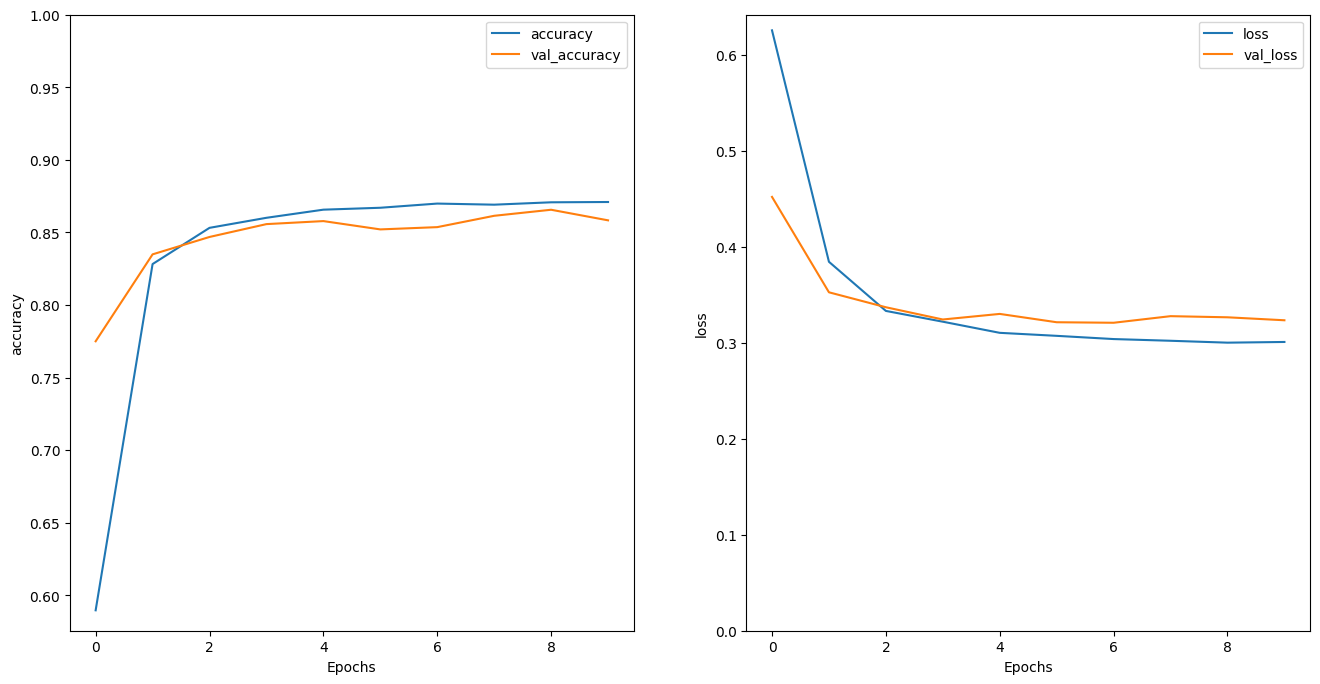

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

kode ini membuat sebuah gambar (figure) yang berisi dua subplot: satu untuk grafik akurasi dan satu untuk grafik loss. plot_graphs diasumsikan sebagai suatu fungsi yang memplot grafik berdasarkan data dari objek history. Anda mungkin perlu melihat atau mendefinisikan kembali fungsi plot_graphs untuk memahami bagaimana grafik akurasi dan loss dihasilkan dan dipresentasikan.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
 encoder,
 tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
 tf.keras.layers.Dense(64, activation='relu'),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(1)
])

model ini memiliki struktur yang melibatkan proses vektorisasi teks, embedding, pemrosesan LSTM bidireksional, beberapa lapisan Dense, dropout untuk regularisasi, dan output layer untuk prediksi. Model ini dirancang untuk tugas seperti analisis sentimen di mana informasi urutan dalam teks penting.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
 optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1260s 3s/step - loss: 0.6513 - accuracy: 0.5591 - val_loss: 0.4936 - val_accuracy: 0.7792
Epoch 2/10
391/391 [==============================] - 1207s 3s/step - loss: 0.4317 - accuracy: 0.8054 - val_loss: 0.3838 - val_accuracy: 0.8146
Epoch 3/10
391/391 [==============================] - 1211s 3s/step - loss: 0.3771 - accuracy: 0.8360 - val_loss: 0.3515 - val_accuracy: 0.8411
Epoch 4/10
391/391 [==============================] - 1214s 3s/step - loss: 0.3494 - accuracy: 0.8512 - val_loss: 0.3472 - val_accuracy: 0.8344
Epoch 5/10
391/391 [==============================] - 1210s 3s/step - loss: 0.3251 - accuracy: 0.8602 - val_loss: 0.3249 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 1217s 3s/step - loss: 0.3163 - accuracy: 0.8634 - val_loss: 0.3203 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 1223s 3s/step - loss: 0.3092 - accuracy: 0.8666 - val_loss: 0.3200 - val_accuracy:

Variabel history menyimpan informasi mengenai proses pelatihan, seperti akurasi dan loss, untuk setiap epoch. Ini dapat digunakan untuk analisis lebih lanjut atau visualisasi performa model.
Proses pelatihan model menggunakan fit ini memanfaatkan dataset pelatihan dan validasi yang sudah disiapkan sebelumnya. Model akan diupdate berdasarkan loss yang dihasilkan selama proses pelatihan. Setelah proses pelatihan selesai, Anda dapat menggunakan history untuk memahami bagaimana performa model berkembang seiring waktu pada data pelatihan dan validasi.

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 263s 674ms/step - loss: 0.3163 - accuracy: 0.8582
Test Loss: 0.3163456320762634
Test Accuracy: 0.8581600189208984


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 8s 8s/step
[[-1.55659]]


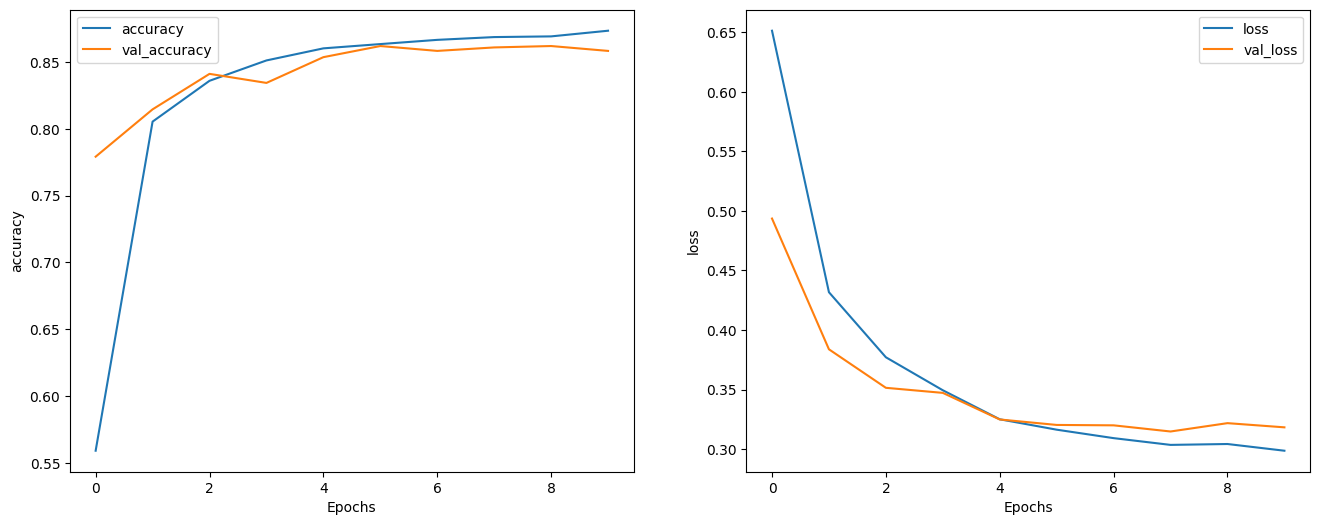

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

kode ini membuat sebuah gambar (figure) yang berisi dua subplot: satu untuk grafik akurasi dan satu untuk grafik loss. plot_graphs diasumsikan sebagai suatu fungsi yang memplot grafik berdasarkan data dari objek history. Anda mungkin perlu melihat atau mendefinisikan kembali fungsi plot_graphs untuk memahami bagaimana grafik akurasi dan loss dihasilkan dan dipresentasikan.

# Praktikum 2

**Setup**

 Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [ ]:
path_to_file=tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


 kode program ini digunakan untuk mendownload file teks Shakespeare dari internet dan menyimpannya di suatu lokasi yang dapat diakses melalui path yang diberikan oleh variabel path_to_file.

Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


keseluruhan kode ini membaca file teks yang telah diunduh, mendekode isinya, dan kemudian mencetak panjang (jumlah karakter) dari teks tersebut.

In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



kode ini memberikan tampilan awal dari isi teks dengan mencetak 250 karakter pertama ke konsol. Hal ini berguna untuk mendapatkan gambaran umum tentang struktur dan konten awal dari teks yang sedang diolah.

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


kode diatas berguna untuk mencetakjumlah  karaketer yang unik

**Olah** **Teks**

Vectorize Teks

In [ ]:
example_texts=['abcdefg','xyz']
chars=tf.strings.unicode_split(example_texts,input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars=tf.keras.layers.StringLookup(
vocabulary=list(vocab),mask_token=None)

In [ ]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars,axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids),axis=-1)

Membuat Training Set dan Target

In [ ]:
all_ids=ids_from_chars(tf.strings.unicode_split(text,'UTF-8'))
all_ids
ids_dataset=tf.data.Dataset.from_tensor_slices(all_ids)
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))
seq_length = 100

F
i
r
s
t
 
C
i
t
i


Secara keseluruhan, kode ini melibatkan proses pengolahan teks yang mencakup konversi karakter menjadi ID, pembuatan dataset, dan pengambilan 10 contoh urutan karakter unicode untuk ditampilkan. Selain itu, panjang urutan sebesar 100 juga telah didefinisikan untuk digunakan di langkah-langkah berikutnya.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


kode ini berguna untuk melihat struktur dan konten dari satu batch pertama dari urutan karakter unicode setelah diubah dari ID. Proses ini dapat membantu pemahaman lebih lanjut tentang bagaimana data sedang diproses dan disiapkan untuk digunakan dalam pelatihan atau pemodelan lebih lanjut.

In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


kode ini berguna untuk melihat hasil teks yang dihasilkan dari lima batch pertama urutan karakter unicode. Ini dapat memberikan wawasan lebih lanjut tentang struktur dan konten data yang sedang diproses dan digunakan dalam konteks tertentu, seperti dalam pemodelan atau pelatihan menggunakan TensorFlow.

In [ ]:
def split_input_target(sequence):

  input_text = sequence[:-1]
  target_text=sequence[1:]
  return input_text,target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
  print("Input :",text_from_ids(input_example).numpy())
  print("Target:",text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Fungsi split_input_target diimplementasikan untuk memisahkan urutan input dan target dari setiap urutan karakter unicode, yang mungkin digunakan dalam konteks pemodelan atau pelatihan untuk memprediksi karakter berikutnya dalam suatu urutan.


Membuat Batch Training

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

, MyModel adalah model dengan lapisan embedding, lapisan GRU, dan lapisan Dense. Model ini dapat digunakan untuk tugas generasi teks atau tugas sejenis.






In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Uji Model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


kedua blok ini memberikan informasi yang berguna untuk memahami output dari model pada satu batch dan struktur keseluruhan arsitektur model, termasuk jumlah parameter dan ukuran lapisan-lapisan yang digunakan.

In [ ]:
sampled_indices=tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices=tf.squeeze(sampled_indices,axis=-1).numpy()

Training Model

In [ ]:
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1885085, shape=(), dtype=float32)


 kode ini digunakan untuk mengukur performa model pada suatu batch data dengan menghitung loss dan mencetak bentuk prediksi serta nilai rata-rata loss. Implementasi lebih lanjut dari model dan loss function tidak diberikan dalam potongan kode tersebut.

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.92439

In [ ]:
model.compile(optimizer='adam',loss=loss)

Konfigurasi Checkpoin

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training

In [ ]:
EPOCHS=20
history=model.fit(dataset,epochs=EPOCHS,callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 981s 6s/step - loss: 2.7119
Epoch 2/20
172/172 [==============================] - 916s 5s/step - loss: 1.9845
Epoch 3/20
172/172 [==============================] - 921s 5s/step - loss: 1.7051
Epoch 4/20
172/172 [==============================] - 920s 5s/step - loss: 1.5452
Epoch 5/20
172/172 [==============================] - 921s 5s/step - loss: 1.4483
Epoch 6/20
172/172 [==============================] - 918s 5s/step - loss: 1.3807
Epoch 7/20
172/172 [==============================] - 917s 5s/step - loss: 1.3280
Epoch 8/20
172/172 [==============================] - 912s 5s/step - loss: 1.2834
Epoch 9/20
172/172 [==============================] - 911s 5s/step - loss: 1.2431
Epoch 10/20
172/172 [==============================] - 911s 5s/step - loss: 1.2029
Epoch 11/20
172/172 [==============================] - 920s 5s/step - loss: 1.1631
Epoch 12/20
172/172 [==============================] - 912s 5s/step - loss: 1.1230
Epoch 13/20
1

, kode ini menjalankan proses pelatihan model dengan melakukan sejumlah epoch yang ditentukan (20 dalam hal ini) menggunakan dataset yang diberikan. Callback checkpoint_callback kemungkinan digunakan untuk menyimpan model selama proses pelatihan.

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

Kelas ini digunakan untuk mengimplementasikan satu langkah (step) dari proses generasi teks dengan menggunakan model tertentu.

In [ ]:
one_step_model = OneStep(model,chars_from_ids,ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Why, Bohemia: she did stay:
To make thee nothing of thy mother's head!
Now are o'Tentime here are come to stale.

QUEEN MARGARET:
Peace, Grumio! it is no mortal bed;
On me, how hence with sught in were good
That he hath sooner of me in's,
That I, poor Rebis, and all nere-bold spirit
Liking for my commoding Reward
Of Seeasons we good dwalth, and cap it be
To bear upon the stirring the voice:
If I may come to speak, setion.

GREEN:
Alas, it were borne you: Lord Angelo, I come
To yield the town and revels enough,
Which down thee fair? The king shall not endure
From off noses of death?

SICINIUS:
How art thou suffer'st! Were not inquirity,
Whereof will choler, fearful hish for,
snew-herd, my sword up; fond, captain,--
And make our hearts and all restraining should
Than death example's gift? O most hostly
for these eyes to command, who began to bed.
What transport of state? it is no other's regiment
Thy peace of mine, thou liest in beoking
To the open alive and cheer:
The daughter of

kode ini menggunakan model one_step_model untuk menghasilkan teks sepanjang 1000 karakter berdasarkan seed awal 'ROMEO:' dan mencetak hasilnya bersama dengan waktu yang dibutuhkan untuk menjalankan proses tersebut.






In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nTruly, Peter to't. Ay, by my holiar heart!\n\nPETRUCHIO:\nI pray you, lady!\n\nLADY CAPULET:\nO most that cease; he has a maid would speak,\nAnd less the east fall of sense,\nSuch a desire of the northent of their shims.\n\nKATHARINA:\nYet I tell thee, may, round aloof, and live.\nWhat, nobly Herchuse will he be freed\nAnd creed ill-dinded bed:s like enemies.\n\nBIANCA:\nTranio, never keep your infant.\nWhat, is it that tell us the temperous and usurps\nWhich is enter'd intent? What should she?\nA drum, she bod's corse to my misdre!\n\nFirst Citizen:\nHe shall, stee: alive, and leave you'll meet!\nO sweetly, vowsaris! Who is his house told.\n\nQUEEN MARGARET:\nReapol, it father, monthor, speaks!\nTheir pleasures he have spider'd there.\n\nFirst Servant:\nAy.\n\nPETRUCHIO:\nNo more.\n\nFLORIZEL:\nWas ever raise this bosom and your feirs: thou'rt all\nafread too need goes well.\n\nDUCHESS OF YORK:\nDown you so wish!\n\nKATHARINA:\nFetch him to pieces. I met me all G

 kode ini melakukan generasi teks sepanjang 1000 karakter untuk setiap seed awal yang diberikan dan mencetak hasilnya bersama dengan waktu yang dibutuhkan untuk menjalankan proses tersebut.

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
O proper you, lords, be taible degleest.

ADRIAN:
Tut, fair, be mercy! you, my lord,
Let Richmond i


kode ini menggunakan model yang telah dimuat kembali (one_step_reloaded) untuk menghasilkan teks sepanjang 100 karakter berdasarkan seed awal 'ROMEO:' dan mencetak hasilnya. Tidak ada waktu eksekusi yang diukur dalam kode ini.